In [ ]:
# Aligns a score volume with an annotation volume

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from registration_utilities import *

In [3]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_labels = len(labels)

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded_list))

# colors = np.random.randint(0, 255, (len(labels_index), 3))
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[labels_index['BackG']] = 1.

In [4]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [6]:
volume1 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_MD589_annotation.bp'))
# atlas_ydim, atlas_xdim, atlas_zdim = volume1.shape
# print atlas_xdim, atlas_ydim, atlas_zdim

def parallel_where(l):
    w = np.where(volume1 == l)
    return [w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1, n_labels))

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t))

atlas_xmin, atlas_ymin, atlas_zmin = np.min([np.min(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)
atlas_xmax, atlas_ymax, atlas_zmax = np.max([np.max(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)

atlas_centroid = np.array([.5*atlas_xmin+.5*atlas_xmax, .5*atlas_ymin+.5*atlas_ymax, .5*atlas_zmin+.5*atlas_zmax])
# atlas_cx, atlas_cy, atlas_cz = atlas_centroid

# print atlas_xmin, atlas_xmax, atlas_ymin, atlas_ymax, atlas_zmin, atlas_zmax
print atlas_centroid

[ 404.5  202.   266.5]


load atlas: 1.256725 seconds


In [ ]:
def unique_rows(a, return_index=True):
    # http://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array   
    b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
    _, idx = np.unique(b, return_index=True)
    unique_a = a[idx]
    if return_index:
        return unique_a, idx
    else:
        return unique_a
    
def unique_rows2(a):
    ind = np.lexsort(a.T)
    return a[np.concatenate(([True],np.any(a[ind[1:]]!=a[ind[:-1]],axis=1)))]

In [7]:
stack = 'MD594'

atlasAlignParams_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams'

with open(atlasAlignParams_dir + '/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
    lines = f.readlines()
    
T_final = np.array(map(float, lines[1].strip().split()))

In [8]:
def surr_points(arr):
    poly = Polygon(arr)
    p1 = points_in_polygon(list(poly.buffer(10, resolution=2).exterior.coords))
    p2 = points_in_polygon(list(poly.exterior.coords))
    surr_pts = pts_arr_setdiff(p1, p2)
    return surr_pts

def points_in_polygon(polygon):
    pts = np.array(polygon, np.int)
    xmin, ymin = pts.min(axis=0)
    xmax, ymax = pts.max(axis=0)
    nz_ys, nz_xs =np.where(grid_points_in_poly((ymax-ymin+1, xmax-xmin+1), pts-[xmin, ymin]))
    nz2 = np.c_[nz_xs + xmin, nz_ys + ymin]
    return nz2

def pts_arr_setdiff(nz1, nz2):
    # http://stackoverflow.com/a/11903368
    a1_rows = nz1.view([('', nz1.dtype)] * nz1.shape[1])
    a2_rows = nz2.view([('', nz2.dtype)] * nz2.shape[1])
    surr_nzs = np.setdiff1d(a1_rows, a2_rows).view(nz1.dtype).reshape(-1, nz1.shape[1])
    return surr_nzs

In [30]:
from collections import defaultdict

surr_volume = defaultdict(list)
for z in range(volume1.shape[2]):
    cnts = find_contour_points(volume1[..., z])
    for l, cnt in cnts.iteritems():
        surr_p = surr_points(cnt[0])
        surr_volume[l].append(np.c_[surr_p, z*np.ones(len(surr_p),)])
surr_volume.default_factory = None

del surr_p, cnts

# surr_nzs = {l: np.concatenate(arr_list).astype(np.int16) for l, arr_list in surr_volume.iteritems()}
surr_nzs = [np.concatenate(surr_volume[l]).T.astype(np.int16) for l in range(1, n_labels)]
del surr_volume

In [12]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [13]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [14]:
volume2_allLabels = None

In [157]:
def compute_score_and_gradient_surr(T, l):
    global ds_surr2
    
    Tm = T.reshape((3,4))
    tx, ty, tz = Tm[:, 3]
    A = Tm[:, :3]

    score = 0
    dMdA = np.zeros((12,))

    xs_prime, ys_prime, zs_prime = (np.dot(A, ds_surr2[l-1]) + \
                                np.asarray([tx + test_cx2, 
                                            ty + test_cy2, 
                                            tz + test_cz2])[:,np.newaxis]).astype(np.int16)
    
    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

    if np.count_nonzero(valid) > 0:

        xs_prime_valid = xs_prime[valid]
        ys_prime_valid = ys_prime[valid]
        zs_prime_valid = zs_prime[valid]

        voxel_probs_valid = volume2_allLabels[l-1, ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e4

        score += voxel_probs_valid.sum()

        Sx = dSdxyz[l-1, 0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sy = dSdxyz[l-1, 1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sz = dSdxyz[l-1, 2, ys_prime_valid, xs_prime_valid, zs_prime_valid]

        dxs, dys, dzs = ds_surr2[l-1][:, valid]

#             dMdA += np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
#                           Sy*dxs, Sy*dys, Sy*dzs, Sy,
#                           Sz*dxs, Sz*dys, Sz*dzs, Sz].sum(axis=0)

        q = np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
                      Sy*dxs, Sy*dys, Sy*dzs, Sy,
                      Sz*dxs, Sz*dys, Sz*dzs, Sz]        

        dMdA += q.sum(axis=0)

        del voxel_probs_valid, q, Sx, Sy, Sz, dxs, dys, dzs, xs_prime_valid, ys_prime_valid, zs_prime_valid
        
#         sys.stderr.write('########### %s: %f seconds\n' % (labels[l], time.time() - t1))
        
        del valid, xs_prime, ys_prime, zs_prime
        
    return score, dMdA

In [158]:
def compute_score_and_gradient(T, l):
    global ds2
    
    Tm = T.reshape((3,4))
    tx, ty, tz = Tm[:, 3]
    A = Tm[:, :3]

    score = 0
    dMdA = np.zeros((12,))

    xs_prime, ys_prime, zs_prime = (np.dot(A, ds2[l-1]) + \
                                np.asarray([tx + test_cx2, 
                                            ty + test_cy2, 
                                            tz + test_cz2])[:,np.newaxis]).astype(np.int16)

    valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

    if np.count_nonzero(valid) > 0:

        xs_prime_valid = xs_prime[valid]
        ys_prime_valid = ys_prime[valid]
        zs_prime_valid = zs_prime[valid]

        voxel_probs_valid = volume2_allLabels[l-1, ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e4

        score += voxel_probs_valid.sum()

        Sx = dSdxyz[l-1, 0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sy = dSdxyz[l-1, 1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
        Sz = dSdxyz[l-1, 2, ys_prime_valid, xs_prime_valid, zs_prime_valid]

        dxs, dys, dzs = ds2[l-1][:, valid]

#             dMdA += np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
#                           Sy*dxs, Sy*dys, Sy*dzs, Sy,
#                           Sz*dxs, Sz*dys, Sz*dzs, Sz].sum(axis=0)

        q = np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
                      Sy*dxs, Sy*dys, Sy*dzs, Sy,
                      Sz*dxs, Sz*dys, Sz*dzs, Sz]        

        dMdA += q.sum(axis=0)

        del voxel_probs_valid, q, Sx, Sy, Sz, dxs, dys, dzs, xs_prime_valid, ys_prime_valid, zs_prime_valid
        
#         sys.stderr.write('########### %s: %f seconds\n' % (labels[l], time.time() - t1))
        
        del valid, xs_prime, ys_prime, zs_prime
        
    return score, dMdA

In [17]:
# for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
# for stack in ['MD594']:

    ################# LOAD TEST VOLUME ######################

section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
np.loadtxt(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_limits.txt' % {'stack': stack}), dtype=np.int)

map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
        map_z_to_section[z] = s

93 364


In [18]:
global volume2_allLabels
# volume2_allLabels = []
volume2_allLabels = np.empty((n_labels-1, volume_ymax-volume_ymin+1, volume_xmax-volume_xmin+1, volume_zmax-volume_zmin+1), 
         dtype=np.float16)

for l in range(1, n_labels):

    t = time.time()

    volume2 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_%(label)s.bp' % \
                                                  {'stack': stack, 'label': labels[l]}))

    volume2_cropped = volume2[volume_ymin:volume_ymax+1, volume_xmin:volume_xmax+1]
    # copy is important, because then you can delete the large array

    volume2_allLabels[l-1] = volume2_cropped.copy()
    
#     volume2_allLabels.append(volume2_cropped.copy())

    del volume2, volume2_cropped
    
    sys.stderr.write('load scoremap %s: %f seconds\n' % (labels[l], time.time() - t))

test_ydim, test_xdim, test_zdim = volume2_allLabels[0].shape
test_centroid = (.5*test_xdim, .5*test_ydim, .5*test_ydim)
test_cx, test_cy, test_cz = test_centroid

print test_xdim, test_ydim, test_zdim
print test_centroid

load scoremap 5N: 2.463680 seconds
load scoremap 7n: 2.158795 seconds
load scoremap 7N: 2.487920 seconds
load scoremap 12N: 2.183586 seconds
load scoremap Pn: 2.557342 seconds
load scoremap VLL: 2.532526 seconds
load scoremap 6N: 2.215885 seconds
load scoremap Amb: 2.169365 seconds
load scoremap R: 2.304958 seconds
load scoremap Tz: 2.193543 seconds
load scoremap RtTg: 2.583855 seconds
load scoremap LRt: 2.368098 seconds
load scoremap LC: 2.738400 seconds
load scoremap AP: 2.189082 seconds


833 473 443
(416.5, 236.5, 236.5)


load scoremap sp5: 2.339800 seconds


In [19]:
dSdxyz = np.empty((n_labels-1, 3) + volume2_allLabels[0].shape, dtype=np.float16) 
# using float16 avoids memory issues that make gradient computation utterly slow

################# COMPUTE GRADIENTS ######################

# dSdxyz = {}
# DO NOT use python list because python will use contiguous memory for it
# http://stackoverflow.com/questions/12274060/does-python-use-linked-lists-for-lists-why-is-inserting-slow  

t1 = time.time()

for l in range(1, n_labels):

    t = time.time()
    
    gy, gx, gz = np.gradient(volume2_allLabels[l-1], 10, 10, 10) # 3.3 second, much faster than loading
    # if memory is limited, this will be very slow
    
    sys.stderr.write('gradient %s: %f seconds\n' % (labels[l], time.time() - t))
    
    t = time.time()
    
    dSdxyz[l-1, 0] = gx
    dSdxyz[l-1, 1] = gy
    dSdxyz[l-1, 2] = gz
    
#     dSdxyz[labels[l]] = np.array([gx, gy, gz]) # use np.array is better; using python list also causes contiguous memory overhead
    
#     del gx, gy, gz # does not make a difference
    
    sys.stderr.write('store %s: %f seconds\n' % (labels[l], time.time() - t))
    
sys.stderr.write('overall: %f seconds\n' % (time.time() - t1))

gradient 5N: 29.040651 seconds
store 5N: 4.887688 seconds
gradient 7n: 28.555289 seconds
store 7n: 4.331295 seconds
gradient 7N: 28.838968 seconds
store 7N: 4.874309 seconds
gradient 12N: 29.485890 seconds
store 12N: 4.359261 seconds
gradient Pn: 29.182601 seconds
store Pn: 4.489133 seconds
gradient VLL: 29.254765 seconds
store VLL: 5.251806 seconds
gradient 6N: 28.808660 seconds
store 6N: 4.391877 seconds
gradient Amb: 28.864976 seconds
store Amb: 4.379865 seconds
gradient R: 29.061461 seconds
store R: 4.993960 seconds
gradient Tz: 28.982592 seconds
store Tz: 4.404521 seconds
gradient RtTg: 29.559386 seconds
store RtTg: 5.195010 seconds
gradient LRt: 29.393313 seconds
store LRt: 4.661776 seconds
gradient LC: 29.216734 seconds
store LC: 5.071261 seconds
gradient AP: 30.515138 seconds
store AP: 4.460640 seconds
gradient sp5: 35.884349 seconds
store sp5: 4.498959 seconds
overall: 514.910248 seconds


In [137]:
Tm0 = T_final.reshape((3,4))
tx0, ty0, tz0 = Tm0[:, 3]
A0 = Tm0[:, :3]

atlas_nzs2 = [(np.dot(A0, nzs - atlas_centroid[:,None]) + \
                            np.asarray([tx0 + test_cx, 
                                        ty0 + test_cy, 
                                        tz0 + test_cz])[:,np.newaxis]).astype(np.int16) for nzs in atlas_nzs]

# atlas_xmin2, atlas_ymin2, atlas_zmin2 = np.min([np.min(atlas_nzs2[l-1], axis=1) for l in range(1, n_labels)], axis=0)
# atlas_xmax2, atlas_ymax2, atlas_zmax2 = np.max([np.max(atlas_nzs2[l-1], axis=1) for l in range(1, n_labels)], axis=0)

# atlas_centroid2 = np.array([.5*atlas_xmin2 + .5*atlas_xmax2, 
#                            .5*atlas_ymin2 + .5*atlas_ymax2,
#                            .5*atlas_zmin2 + .5*atlas_zmax2])

atlas_centroid2 = atlas_nzs2[labels_index['AP']-1].T.mean(axis=0)

# atlas_cx2, atlas_cy2, atlas_cz2 = atlas_centroid2

# print atlas_xmin2, atlas_xmax2, atlas_ymin2, atlas_ymax2, atlas_zmin2, atlas_zmax2
print atlas_centroid2

[ 612.23319814  164.25910699  233.05933663]


In [109]:
surr_nzs2 = [(np.dot(A0, nzs - atlas_centroid[:,None]) + \
                    np.asarray([tx0 + test_cx, 
                                ty0 + test_cy, 
                                tz0 + test_cz])[:,np.newaxis]).astype(np.int16) for nzs in surr_nzs]

In [156]:
test_cx2, test_cy2, test_cz2 = atlas_centroid2

In [134]:
# ds_surr2 = []
# for l in range(1, n_labels):
#     ds_surr2.append(surr_nzs2[l-1] - atlas_centroid2[:, None])
    
# ds2 = []
# for l in range(1, n_labels):
#     ds2.append(np.array(atlas_nzs2[l-1]) - atlas_centroid2[:, None])

ds_surr2 = [surr_nzs2[l-1] - atlas_centroid2[:, None] for l in range(1, n_labels)]
ds2 = [atlas_nzs2[l-1] - atlas_centroid2[:, None] for l in range(1, n_labels)]    

In [ ]:
del dSdxyz

In [261]:
################# GRADIENT DESCENT ######################

# lr1, lr2 = (1., 1e-1)
lr1, lr2 = (1., 1e-2)

# auto_corr = .95

max_iter_num = 1000
fudge_factor = 1e-6 #for numerical stability
dMdA_historical = np.zeros((12,))

# tx_best, ty_best, tz_best = params_best_upToNow
# T_best = np.r_[1,0,0, tx_best, 0,1,0, ty_best, 0,0,1, tz_best]

# T_best = T_final.copy()

T_best = np.array([1.,0,0, 0, 0,1.,0, 0, 0,0,1., 0])

lr = np.array([lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1])
# lr = np.array([lr2, 0, 0, lr1, 0, lr2, 0, lr1, 0, 0, lr2, lr1])

score_best = 0

scores = []
scores_in = []
scores_out = []
dets = []

for iteration in range(max_iter_num):

#     logger.info('iteration %d', iteration)

#     t = time.time()
    s, dMdA = compute_score_and_gradient(T_best, labels_index['AP'])
#     sys.stderr.write('compute_score_and_gradient 1: %f seconds\n' % (time.time() - t)) #~ 2s/iteration

#     (np.dot(A, ds2[l-1]) + \
#                             np.asarray([tx + test_cx2, 
#                                         ty + test_cy2, 
#                                         tz + test_cz2])[:,np.newaxis]).astype(np.int16)


    scores_in.append(s)

    s_surr, dMdA_surr = compute_score_and_gradient_surr(T_best, labels_index['AP'])
    scores_out.append(s_surr)
        
# # # #     t = time.time()

    dMdA = dMdA - 2.*dMdA_surr
    s = s - 2.*s_surr
        
#     sys.stderr.write('compute_score_and_gradient: %f seconds\n' % (time.time() - t)) #~ 2s/iteration

    dMdA_historical += dMdA**2
#     dMdA_historical = auto_corr * dMdA_historical + (1-auto_corr) * dMdA**2

    dMdA_adjusted = dMdA / (fudge_factor + np.sqrt(dMdA_historical))

    T_best += lr*dMdA_adjusted

#         logger.info('A: ' + ' '.join(['%f']*12) % tuple(A_best))
#         logger.info('dMdA adjusted: ' + ' '.join(['%f']*12) % tuple(dMdA_adjusted))

#     logger.info('score: %f', s)
    scores.append(s)
    dets.append(np.linalg.det(T_best.reshape((3,4))[:3,:3]))

#     logger.info('\n')

    history_len = 50
    if iteration > 10:
        if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                  np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-2:
            break

    if s > score_best:
#         logger.info('Current best')
        best_gradient_descent_params = T_best
        score_best = s

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in absolute


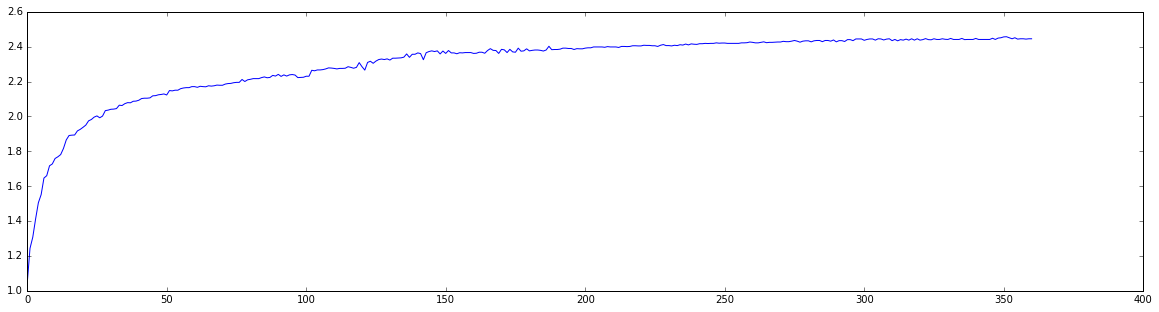

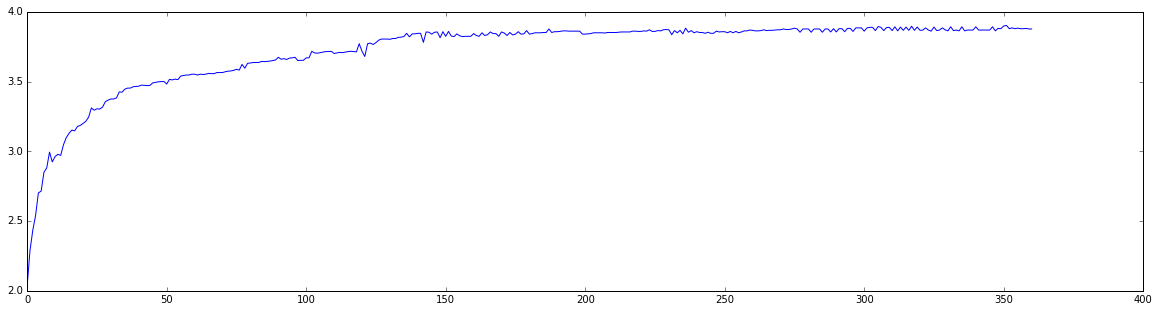

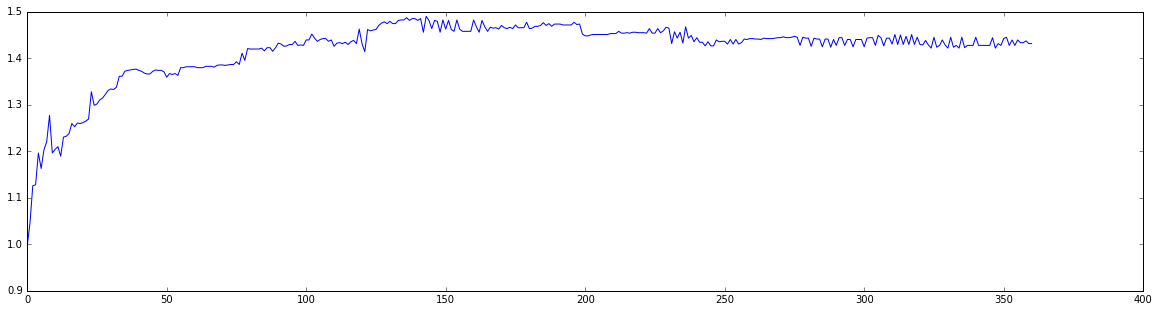

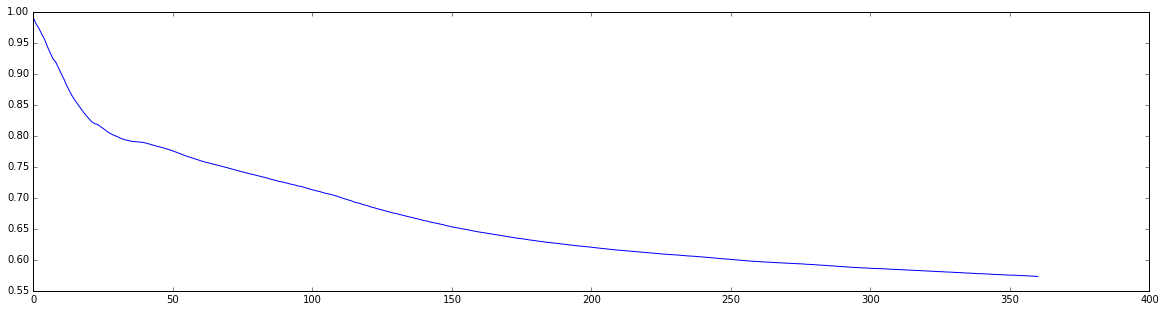

In [256]:
plt.figure(figsize=(20, 5));
plt.plot(scores);
plt.show();

plt.figure(figsize=(20, 5));
plt.plot(scores_in);
plt.show();

plt.figure(figsize=(20, 5));
plt.plot(scores_out);
plt.show();

plt.figure(figsize=(20, 5));
plt.plot(dets);
plt.show();

In [ ]:
# np.save(atlasAlignOptLogs_dir + '/%(stack)s_scoreEvolutions.npy' % {'stack':stack}, scores)

# del dSdxyz

In [257]:
print np.linalg.det(T_final.reshape((3,4))[:3,:3])
print T_final.reshape((3,4))

print np.linalg.det(best_gradient_descent_params.reshape((3,4))[:3,:3])
print best_gradient_descent_params.reshape((3,4))

0.877898376041
[[  9.89607000e-01   2.40036000e-01  -1.37680000e-02   6.78861730e+01]
 [ -2.24423000e-01   8.70130000e-01   6.98430000e-02  -3.74003500e+00]
 [  5.93540000e-02  -7.81530000e-02   9.51993000e-01  -2.57590500e+00]]
0.573136297195
[[ 0.66342158  0.          0.          6.82342866]
 [ 0.          1.13092159  0.         -3.9165063 ]
 [ 0.          0.          0.76389879  7.56776512]]


In [258]:
################# PROJECT ATLAS TO IMAGE ######################

T2 = np.reshape(best_gradient_descent_params, (3,4))
tx_best, ty_best, tz_best  = T2[:, 3]
Amat_best = T2[:, :3]

# atlas_nzs_projected_to_test = [(np.dot(A0, vs - atlas_centroid[:, np.newaxis]) + \
#                                             np.asarray([tx0 + test_cx, 
#                                                         ty0 + test_cy, 
#                                                         tz0 + test_cz])[:,np.newaxis]).astype(np.int)
#                                 for vs in atlas_nzs]

atlas_nzs_projected_to_test = [(np.dot(Amat_best, vs - atlas_centroid2[:, np.newaxis]) + \
                                            np.asarray([tx_best + test_cx2, 
                                                        ty_best + test_cy2, 
                                                        tz_best + test_cz2])[:,np.newaxis]).astype(np.int16)
                                for vs in atlas_nzs2]

# print np.min(atlas_nzs_projected_to_test[0], axis=1)
# print np.max(atlas_nzs_projected_to_test[0], axis=1)

test_volume_atlas_projected = np.zeros_like(volume2_allLabels[0], np.int)

for l in range(1, n_labels):

    test_xs, test_ys, test_zs = atlas_nzs_projected_to_test[l-1].astype(np.int16)

    valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
            (test_xs < test_xdim) & (test_ys < test_ydim) & (test_zs < test_zdim)

    atlas_xs, atlas_ys, atlas_zs = atlas_nzs[l-1]

    test_volume_atlas_projected[test_ys[valid], test_xs[valid], test_zs[valid]] = \
    volume1[atlas_ys[valid], atlas_xs[valid], atlas_zs[valid]]


# del atlas_nzs_projected_to_test

# bp.pack_ndarray_file(test_volume_atlas_projected, 
#                      volume_dir + '/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})

# with open(os.path.join(atlasAlignParams_dir, '%(stack)s_3dAlignParams.txt' % {'stack':stack}), 'w') as f:
#     f.writelines(' '.join(['%f']*len(params_best_upToNow)) % tuple(params_best_upToNow) + '\n')
#     f.writelines(' '.join(['%f']*len(best_gradient_descent_params)) % tuple(best_gradient_descent_params) + '\n')
#     f.writelines(' '.join(['%f']*len(lr)) % tuple(lr) + '\n')
#     f.writelines('%d' % iteration + '\n')

# annotationsViz_dir = create_if_not_exists(annotationsViz_rootdir + '/' + stack)

In [259]:
dm = DataManager(stack=stack)

220


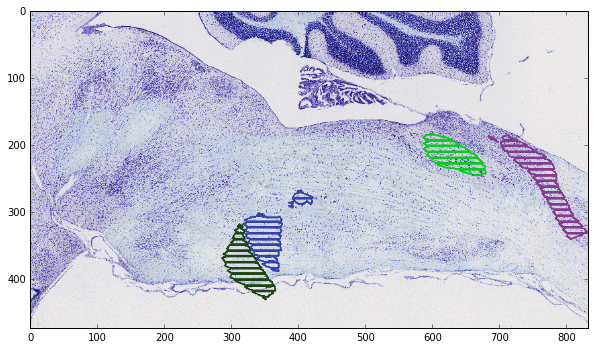

230


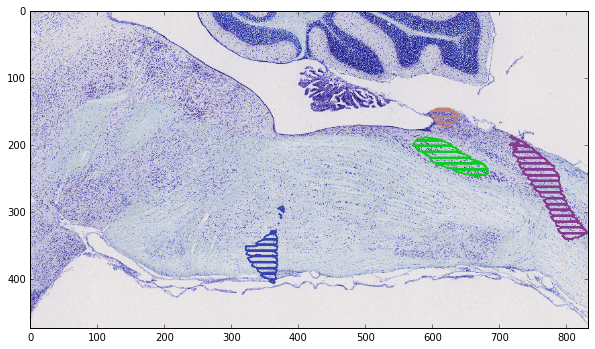

240


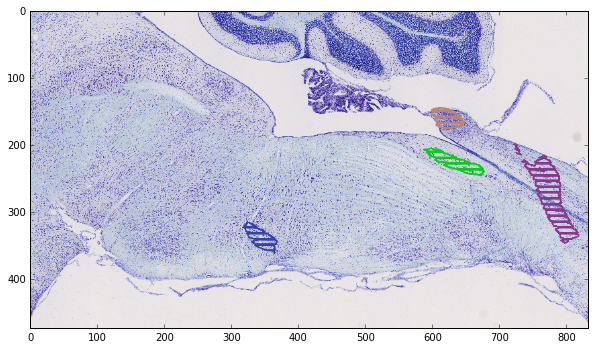

250


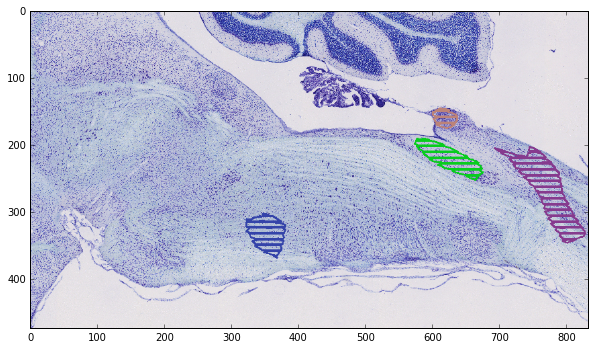

260


KeyboardInterrupt: 

In [260]:
# for z in range(0, test_zdim, 10):
for z in range(220, 270, 10):
    # z = 170
    print z

    dm.set_slice(map_z_to_section[z])
    dm._load_image(versions=['rgb-jpg'])
    viz = dm.image_rgb_jpg[::downsample_factor, ::downsample_factor][volume_ymin:volume_ymax+1, 
                                                                     volume_xmin:volume_xmax+1].copy()

    projected_cnts = find_contour_points(test_volume_atlas_projected[...,z])

    for label_ind, cnts in projected_cnts.iteritems():
        for cnt in cnts:
            cv2.polylines(viz, [cnt.astype(np.int)], True, tuple((colors[label_ind]*255).astype(np.int)), 2)

    plt.figure(figsize=(10, 10));
    plt.imshow(viz)
    plt.show()

    #     cv2.imwrite(annotationsViz_dir + '/%(stack)s_%(sec)04d_annotationsProjectedViz_z%(z)04d.jpg' % \
    #                 {'stack': stack, 'sec': map_z_to_section[z], 'z': z}, 
    #                 img_as_ubyte(viz[..., [2,1,0]]))

    #     del viz


    # del test_volume_atlas_projected

    # logger.removeHandler(handler)